
# Using APIs for Data Imports <a id='btc-sim'></a>

This chapter starts by using [NASDAQ Data Link](https://data.nasdaq.com/tools/api) to download some BTC price and return data. We'll also see our first set of **simulations**. I'll then show you how to use [Pandas Data Reader](https://pandas-datareader.readthedocs.io/en/latest/).

This is also our first time using an **API**. Their API, or Application Programming Interface, let's us talk to a remote data storage system and pull in what we need. APIs are more general, though, and are used whenever you need one application to talk to another.

We'll use the [NASDAQ Data Link](https://data.nasdaq.com/tools/api). They also have [Python specific instructions](https://data.nasdaq.com/tools/python).

You can read about the install [on their package page](https://pypi.org/project/Nasdaq-Data-Link/).


We can again use `pip` to install packages via the command line or in your Jupyter notebook. You can type this directly into a code cell in a notebook in Githib Codespaces. Run that cell.

```
pip install nasdaq-data-link
```

You can also use the `! pip` convention. The ! tells the Jupyter notebook that you want to run a terminal command in that cell. Older notebook environments had to have the !, but Github Codespaces does not.

```
! pip install nasdaq-data-link
```

When you sign-up for NASDAQ Data Link, you'll get an API Key. You will need to add this key to the set-up to access the NASDAQ data using Quandl. 

I have saved my key locally and am bringing it in with `quandl.read_key`, so that it isn't publicly available. You don't need that bit of code.

You can also install `pandas-datareader` using `pip`.

```
pip install pandas-datareader
```

Finally, for a large set of APIs for access data, check out [Rapid API](https://rapidapi.com/hub). Some are free, others you have to pay for. You'll need to get an access API key for each one. More on this at the end of these notes.

Let's do our usual sort of set-up code.

In [1]:
# Set-up

import nasdaqdatalink # You could also do something like: import nasdaqdatalink as ndl
import pandas_datareader as pdr

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib as mpl 

import matplotlib.pyplot as plt

# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

# nasdaqdatalink.ApiConfig.api_key = 'YOUR_KEY_HERE'

nasdaqdatalink.read_key()

#nasdaqdatalink.read_key(filepath="/data/.corporatenasdaqdatalinkapikey")
#print(nasdaqdatalink.ApiConfig.api_key)

In [2]:
gdp = nasdaqdatalink.get('FRED/GDP')
gdp

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2020-10-01,21477.597
2021-01-01,22038.226
2021-04-01,22740.959


In [3]:
btc = nasdaqdatalink.get('BCHAIN/MKPRU')
btc.tail()

,Value
Date,
2024-01-04,42854.95
2024-01-05,44190.10
2024-01-06,44181.10
2024-01-07,43975.63
2024-01-08,43928.07


In [4]:
btc['ret'] = btc.pct_change().dropna()


<AxesSubplot:xlabel='Date'>

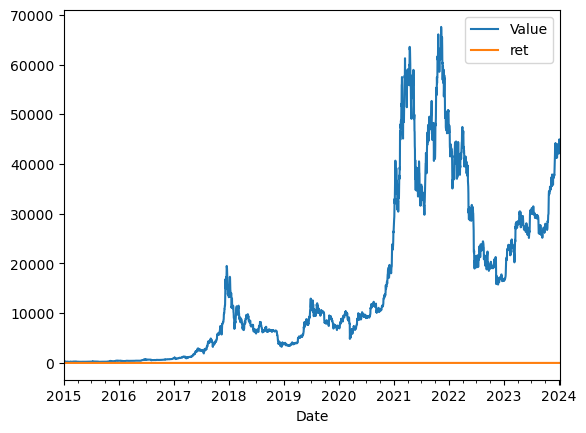

In [5]:
btc = btc.loc['2015-01-01':,['Value', 'ret']]
btc.plot()

Well, that's not a very good graph. The returns and price levels are in different units. Let's use an `f print` to show and format the average BTC return.

In [6]:
print(f'Average return: {100 * btc.ret.mean():.2f}%')

Average return: 0.22%


Let's make a cumulative return chart and daily return chart. We can then stack these on top of each other. I'll use the `.sub(1)` method to subtract 1 from the cumulative product. You see this a lot in the DataCamps.

In [7]:
btc['ret_g'] = btc.ret.add(1) # gross return
btc['ret_c'] = btc.ret_g.cumprod().sub(1)    # cummulative return
btc

,Value,ret,ret_g,ret_c
Date,,,,
2015-01-01,316.15,0.001425,1.001425,0.001425
2015-01-02,314.81,-0.004238,0.995762,-0.002819
2015-01-03,270.93,-0.139386,0.860614,-0.141812
2015-01-04,276.80,0.021666,1.021666,-0.123218
2015-01-05,263.17,-0.049241,0.950759,-0.166392
...,...,...,...,...
2024-01-04,42854.95,-0.046799,0.953201,134.745803
2024-01-05,44190.10,0.031155,1.031155,138.974976
2024-01-06,44181.10,-0.000204,0.999796,138.946468


We can now make a graph using the **fig, axs** method. This is good review! Again, notice that semi-colon at the end. This suppresses some annoying output in the Jupyter notebook. 

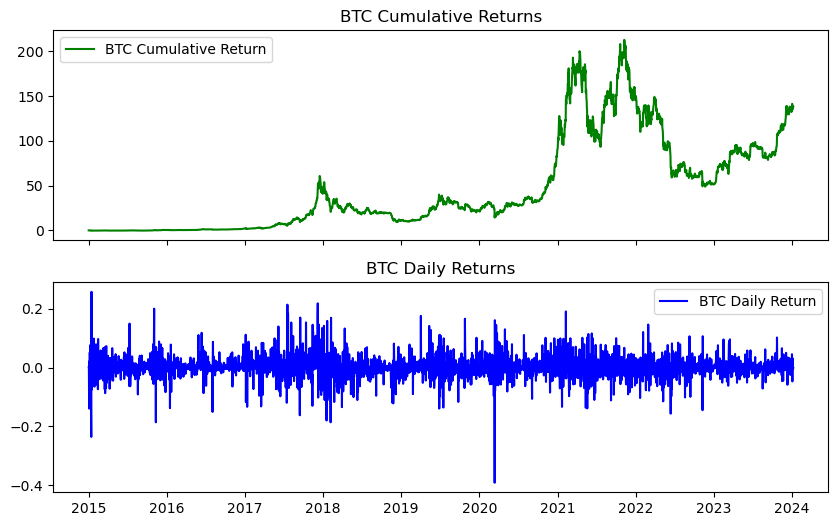

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 6))

axs[0].plot(btc.ret_c, 'g', label = 'BTC Cumulative Return')
axs[1].plot(btc.ret, 'b', label = 'BTC Daily Return')
            
axs[0].set_title('BTC Cumulative Returns')
axs[1].set_title('BTC Daily Returns')

axs[0].legend()
axs[1].legend();




I can make the same graph using the `.add_subplot()` syntax. The method above gives you some more flexibility, since you can give both plots the same x-axis.

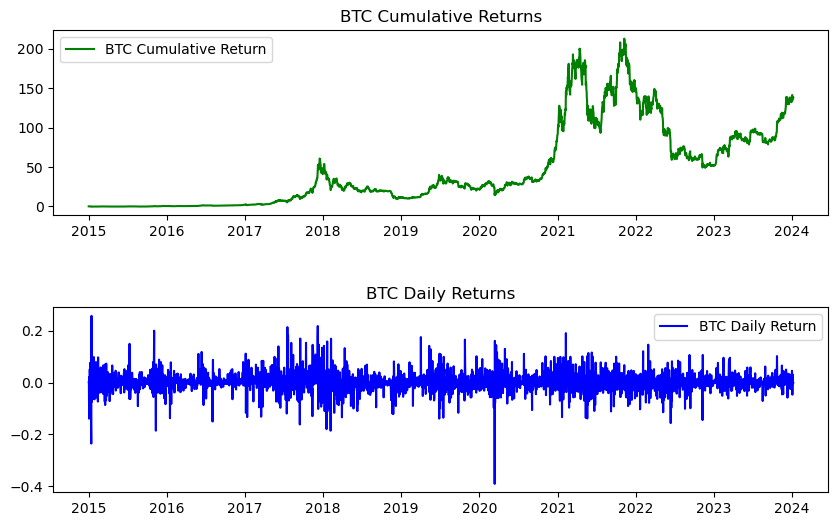

In [9]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(btc.ret_c, 'g', label = 'BTC Cumulative Return')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(btc.ret, 'b', label = 'BTC Daily Return')

ax1.set_title('BTC Cumulative Returns')
ax2.set_title('BTC Daily Returns')

ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.5, hspace=0.5);



Let's put together some ideas, write a function, and run a simulation. We'll use something called **geometric brownian motion** (GBM). What is GBM? It is a particular [stochastic differential equation](https://arxiv.org/pdf/1504.05309.pdf). But, what's important for us is the idea, which is fairly simple. Here's the formula:

\begin{align}
dS = \mu S dt + \sigma S dW_t
\end{align}

This says that the change in the stock price has two components - a **drift**, or average increase over time, and a **shock** that it is random at each point in time. The shock is scaled by the standard deviation of returns that you use. So, larger standard deviation, the bigger the shocks can be. This is basically the simplest way that you can model an asset price.

The shocks are what make the price wiggle around around, or else it would just go up over time, based on the drift value that we use.

And, I'll stress - we aren't predicting here, so to speak. We are trying to capture some basic reality about how an asset moves and then seeing what is possible in the future. We aren't making a statement about whether we think an asset is overvalued or undervalued, will go up or down, etc.

You can solve this equation to get the value of the asset at any point in time t. You just need to know the total of all of the shocks at time t.

\begin{align}
S(t) = S(0) \exp \left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W(t)\right)
\end{align}

In [10]:
T = 30 # How long is our simulation? Let's do 31 days (0 to 30 the way Python counts)
N = 30 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
S_0 = btc.Value[-1] # initial BTC price
N_SIM = 100      # How many simulations to run?
mu = btc.ret.mean()
sigma = btc.ret.std()

This is the basic syntax for writing a function in Python. We saw this earlier, back when doing "Comp 101". Remember, in Python, **indentation matters**!

In [11]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
    dt = T/N # One day
    dW = np.random.normal(scale = np.sqrt(dt), 
        size=(n_sims, N))  # The random part
    W = np.cumsum(dW, axis=1)
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * np.sqrt(time_steps) * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

Nothing happens when we define a function. We've just created something called `simulate_gbm` that we can now use just like any other Python function.

We can look at each piece of the function code, with some numbers hard-coded, to get a sense of what's going on. This gets tricky - keep track of the dimensions. I think that's the hardest part. How many numbers are we creating in each array? What do they mean?

In [12]:
# Creates 100 rows of 30 random numbers from the standard normal distribution.
dW = np.random.normal(scale = np.sqrt(1), 
        size=(100, 30))

# cumulative sum along each row
W = np.cumsum(dW, axis=1) 

# Array with numbers from 1 to 30
time_step = np.linspace(1, 30, 30)

# Expands that to be 100 rows of numbers from 1 to 30. This is going to be the t in the formula above. So, for the price on the 30th day, we have t=30.
time_steps = np.broadcast_to(time_step, (100, 30))

# This is the formula from above to find the value of the asset any any point in time t. np.exp is the natural number e. W is the cumulative sum of all of our random shocks.
S_t = S_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * np.sqrt(time_steps) * W)

# This inserts the initial price at the start of each row.
S_t = np.insert(S_t, 0, S_0, axis=1)


We can look at these individually, too.

In [13]:
dW

array([[ 0.29352934,  1.4035672 ,  2.24752435, ..., -0.01102982,
        -0.0166626 , -0.40032427],
       [ 0.22013551,  0.87713185,  0.57813185, ...,  1.68700397,
         1.25391254,  0.06919583],
       [-1.34203549,  1.65230766,  1.09702783, ...,  0.99141456,
        -0.09264651,  1.35555923],
       ...,
       [-0.31471884,  1.27557388, -0.37149274, ...,  0.55027748,
        -0.03737135,  0.63205208],
       [-1.29561229, -0.15858351, -0.16997573, ..., -1.5500822 ,
         0.94322257, -0.81749369],
       [ 0.52524517,  0.22560095, -0.38460592, ...,  0.68263448,
        -0.34514022,  0.31080324]])

In [14]:
time_steps

array([[ 1.,  2.,  3., ..., 28., 29., 30.],
       [ 1.,  2.,  3., ..., 28., 29., 30.],
       [ 1.,  2.,  3., ..., 28., 29., 30.],
       ...,
       [ 1.,  2.,  3., ..., 28., 29., 30.],
       [ 1.,  2.,  3., ..., 28., 29., 30.],
       [ 1.,  2.,  3., ..., 28., 29., 30.]])

In [15]:
len(time_steps)

100

In [16]:
np.shape(time_steps)

(100, 30)

I do this kind of step-by-step break down **all of the time**. It's the only way I can understand what's going on.

We can then use our function. This returns an `narray`. 

In [17]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

And, we can plot all of the simulations. I'm going to use `pandas` to plot, save to `ax`, and the style the `ax`.

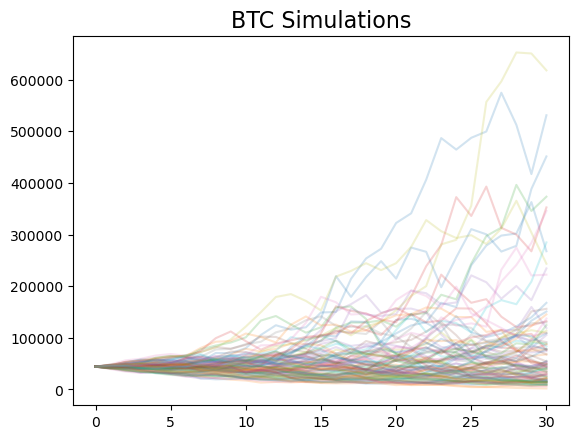

In [18]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)

ax.set_title('BTC Simulations', fontsize=16);


The y-axis has a very wide range, since some extreme values are possible, given this simulation.

## Using pandas-datareader

The [pandas data-reader](https://pydata.github.io/pandas-datareader/) API lets us access additional data sources, such as [FRED](https://fred.stlouisfed.org). 

There are also API that let you access the same data. For example, Yahoo! Finance has several, like [yfinance](https://pypi.org/project/yfinance/). I find accessing Yahoo! Finance via an API to be very buggy - Yahoo! actively tries to stop it. So, you can try those instructions, but they may or may not work.

Lots of developers have written APIs to access different data sources. 

```{note}
Different data sources might require API keys. Sometimes you have to pay. Always read the documentation.
```

Here's another FRED example, but using `pandas-datareader`.

In [19]:
start = dt.datetime(2010, 1, 1)

end = dt.datetime(2013, 1, 27)

gdp = pdr.DataReader('GDP', 'fred', start, end)

gdp.head

<bound method NDFrame.head of                   GDP
DATE                 
2010-01-01  14764.610
2010-04-01  14980.193
2010-07-01  15141.607
2010-10-01  15309.474
2011-01-01  15351.448
2011-04-01  15557.539
2011-07-01  15647.680
2011-10-01  15842.259
2012-01-01  16068.805
2012-04-01  16207.115
2012-07-01  16319.541
2012-10-01  16420.419
2013-01-01  16648.189>

## Data Details - Using APIs

This notes above use the [NASDAQ Datalink API](https://www.nasdaq.com/nasdaq-data-link) to pull some BTC data. Now, I'll discuss using this API more generally, as well as using [Rapid API](https://rapidapi.com/hub), another website with a variety of data options. I'll also show you an API from Github.

As mentioned above, APIs are ways for one program or piece of software to talk to another. In our case, we're using them to get data. That data might come in as a `pandas` DataFrame, ready to use. Other times, it might come in as something called a [JSON](https://realpython.com/python-json/) file. We'll have to do a bit more work with this common data structure. 

### NASDAQ API - Another Example

Let's look at the NASDAQ API one more time. Once you log in, you'll see the home page below. Note the strip across the upper-left, that has API, Python, Excel, etc. You can use the NASDAQ API in a variety of settings. There's a **SEARCH FOR DATA** box at the top. 

```{figure} ../images/07-nasdaq-home.png
---
name: 07-nasdaq-home.png
align: center
---
NASDAQ API homepage.
```

If you click **EXPLORE** next to the search box, you're taken to a list of all of their data. Much of it is premium - you have to pay. However, you can filter for free data. There's free data for house prices, gold and silver markets, IMF macro data, the Fed, etc. Much of this free data comes from Quandl, which was purchased by Nasdaq recently. 

Quandl has been completely integrated by NASDAQ now, though you will see legacy instructions on the website that refer to its older API commands.

```{figure} ../images/07-nasdaq-explore.png
---
name: 07-nasdaq-explore.png
align: center
---
Exploring NASDAQ data options.
```

Let's look at the Zillow data, the first option presented when I look for free data. I've used them in labs and exams. 

```{figure} ../images/07-nasdaq-zillow.png
---
name: 07-nasdaq-zillow.png
align: center
---
NASDAQ has an API for Zillow housing data.
```

Each the data APIs shows you samples of what you can access. So, we see an example table with data for a particular indicator and region. We also see a table that has a list of all of the indicators and what they measure. Finally, we see a table with all of the regions and what they represent.

This data structure makes it clear that we can download value data and then merge in ID and region descriptions if needed. But, how do we do that? See the tab in the upper-left, with **DATA** highlighted? You can click on **DOCUMENTATION** and **USAGE** to learn more. We'll look at a quick example here.

Click **USAGE** and then the **Python** icon. You'll seen an example that lets you filter by a single *indicator_id* and *region*. It has your API key and the `.get_table` method. 

However, note the `quandl` stuff. They haven't transitioned this code yet. You'll need to do a `pip` install for quandl.

Also, we didn't use `.get_table` above for BTC. The Zillow data is stored differently. 

Make sure that you include your API key. You can input it directly, using the code that they provide. I'm using a different way to do the key that doesn't require me to type my API key into this publicly available code.

In [20]:
#! pip install quandl

# Bring in quandl for downloading data
import quandl
# quandl.ApiConfig.api_key = 'YOUR_KEY_HERE'
quandl.read_key()


You need that `paginate=True` in there in order to download all of the available data. Without it, it will only pull the first 10,000 rows. Using paginate extends the limit to 1,000,000 rows, or observations. Now, note that this could be a lot of data! You might need to download the data in chunks to get what you want.

Let's try pulling in the *indicator_id* ZATT for all regions. 

In [21]:
# zillow = quandl.get_table('ZILLOW/DATA', indicator_id = 'ZATT', paginate=True)

I've commented out the code above, because I know it will exceed the download limit! So, we need to be more selective.

If you look on the NASDAQ Zillow documentation page, you'll see the three tables that you can download, the variables inside of each, and what you're allowed to filter on. You unfortunately can't filter on date in the ZILLOW/DATA table. Other data sets, like FRED, do let you specify start and end dates. Every API is different. 

You can find examples of how to filter and sub-select your data on the NASDAQ website: [https://docs.data.nasdaq.com/docs/python-tables](https://docs.data.nasdaq.com/docs/python-tables)

However, you can filter on *region_id*. Let's pull the ZILLOW/REGIONS table to see what we can use.

In [22]:
regions = quandl.get_table('ZILLOW/REGIONS', paginate=True)

In [23]:
regions

,region_id,region_type,region
None,,,
0,99999,zip,"98847;WA;Wenatchee, WA;Leavenworth;Chelan County"
1,99998,zip,98846;WA;nan;Pateros;Okanogan County
2,99997,zip,98845; WA; Wenatchee; Douglas County; Palisades
3,99996,zip,98844;WA;nan;Oroville;Okanogan County
4,99995,zip,"98843;WA;Wenatchee, WA;Orondo;Douglas County"
...,...,...,...
89300,100000,zip,"98848;WA;Moses Lake, WA;Quincy;Grant County"
89301,10000,city,Bloomington;MD;nan;Garrett County
89302,1000,county,"Echols County;GA;Valdosta, GA"


What if we just want cities?

In [24]:
cities = regions[regions.region_type == 'city']
cities

,region_id,region_type,region
None,,,
10,9999,city,Carrsville;VA;Virginia Beach-Norfolk-Newport N...
20,9998,city,Birchleaf;VA;nan;Dickenson County
56,9994,city,"Wright;KS;Dodge City, KS;Ford County"
124,9987,city,"Weston;CT;Bridgeport-Stamford-Norwalk, CT;Fair..."
168,9980,city,South Wilmington; IL; Chicago-Naperville-Elgin...
...,...,...,...
89203,10010,city,Atwood;KS;nan;Rawlins County
89224,10008,city,"Bound Brook;NJ;New York-Newark-Jersey City, NY..."
89254,10005,city,Chanute;KS;nan;Neosho County


In [25]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28125 entries, 10 to 89301
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   region_id    28125 non-null  object
 1   region_type  28125 non-null  object
 2   region       28125 non-null  object
dtypes: object(3)
memory usage: 878.9+ KB


I like to look and see what things are stored as, too. Remember, the `object` type is very generic. 

There are 28,131 rows of cities! How about counties?

In [26]:
counties = regions[regions.region_type == 'county']
counties

,region_id,region_type,region
None,,,
94,999,county,"Durham County;NC;Durham-Chapel Hill, NC"
169,998,county,Duplin County;NC;nan
246,997,county,"Dubois County;IN;Jasper, IN"
401,995,county,Donley County;TX;nan
589,993,county,Dimmit County;TX;nan
...,...,...,...
89069,1003,county,"Elmore County;AL;Montgomery, AL"
89120,1002,county,Elbert County;GA;nan
89204,1001,county,"Elbert County;CO;Denver-Aurora-Lakewood, CO"


Can't find the regions you want? You could export the whole thing to a CSV file and explore it in Excel. This will show up in whatever folder you currently have as your home in VS Code.

In [27]:
counties.to_csv('counties.csv', index = True)

You can also open up the **Variables** window at the top of VS Code (or the equivalent in Google Colab) and scroll through the file, looking for the *region_id* values that you want. 

Finally, you can search the text in a column directly. Let's find counties in NC.

In [28]:
nc_counties = counties[counties['region'].str.contains("; NC")]
nc_counties

,region_id,region_type,region
None,,,


In [29]:
nc_counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   region_id    0 non-null      object
 1   region_type  0 non-null      object
 2   region       0 non-null      object
dtypes: object(3)
memory usage: 0.0+ bytes


There are 100 counties in NC, so this worked. Now, we can save these regions to a **list** and use that to pull data.

By exploring the data like this, you can maybe find the *region_id* values that you want and give them as a list. I'm also going to use the `qopts = ` option to name the columns that I want to pull. This isn't necessary here, since I want all of the columns, but I wanted to show you that you could do this.

In [30]:
nc_county_list = nc_counties['region_id'].to_list()

In [31]:
zillow_nc = quandl.get_table('ZILLOW/DATA', indicator_id = 'ZATT', paginate = True, region_id = nc_county_list,  qopts = {'columns': ['indicator_id', 'region_id', 'date', 'value']})

LimitExceededError: This call exceeds the amount of data that quandl.get_table() allows.         Please use the following link in your browser, which will download the full results as         a CSV file: https://www.quandl.com/api/v3/datatables/ZILLOW/DATA?qopts.export=true&api_key=kVxf2sQJhQbFtym4MXv3 . See         our API documentation for more info:         https://docs.quandl.com/docs/in-depth-usage-1#section-download-an-entire-table

In [ ]:
zillow_nc.head(25)

Hey, there's Durham County!

In [ ]:
zillow_nc.info()

Now you can filter by *date* if you like. And, you could pull down multiple states this way, change the variable type, etc. You could also merge in the region names using *region_id* as your key.

### Using Rapid API

Another data option is [Rapid API](https://rapidapi.com/hub). There's all types of data here - markets, sports, gambling, housing, etc. People will write their own APIs, perhaps interfacing with the websites that contain the information. They can then publish their APIs on this webpage. Many have free options, some you have to pay for. There are thousands here, so you'll have to dig around.

```{figure} ../images/07-rapidapi.png
---
name: 07-rapidapi.png
align: center
---
Main Rapid API webpage
```

One you have an account, you'll be able to subscribe to different APIs. You probably want the data to have a free option.

The quick start guide is [here](https://docs.rapidapi.com/docs/consumer-quick-start-guide). 

Luckily, all of the APIs here tend to have the same structures. These are called **REST APIs**. This stands for "Representational State Transfer" and is just a standardized way for computers to talk to each other. They are going to use a standard data format, like JSON. More on this below.

You can read more on their [API Learn page](https://rapidapi.com/learn/rest). 

We'll look at one example, Pinnacle Odds, which has some sports gambling information: [https://rapidapi.com/tipsters/api/pinnacle-odds/](https://rapidapi.com/tipsters/api/pinnacle-odds/)

Once you've subscribed, you see the main **endpoint** screen. 

```{figure} ../images/07-rapidapi-endpoint.png
---
name: 07-rapidapi-endpoint.png
align: center
---
Pinnacle Odds endpoint page. I've blocked my API key with two different windows.
```

At the top, you'll see Endpoints, About, Tutorials, Discussions, and Pricing. Click around to read more about the API.

We are currently on **Endpoints**. Endpoints are basically like URLs. They are where different tables of data live. We are going to use this page to figure out the data that we need. And, the webpage page will also create the Python code needed to download the data!

You can start on the left of the screen. You'll see a list of the different tables available. I'll try **List of Sports** in this example. You'll see why in a minute.

You'll note that the middle section now changed. This is where you can filter and ask for particular types of data from that table. In this case, there are no options to change.

On the right, you'll see Code Snippets. The default is Node.js, a type of Javascript. We don't want that. Click the dropdown box and look for Python. They have three ways, using three different packages, to interface with the API from Python and download the data. I'll pick `Requests` - it seemed to work below. 

This will change the code. You'll see the package import, your API key, the host, and the data request. You can click **Copy Code**. 

But, before we run this on our end, let's click **Test Endpoint**. That's the blue box in the middle. Then, click **Results** on the left and **Body**. By doing this, we essentially just ran that code in the browser. We can see what data we're going to get. This is a **JSON file** with 9 items. Each item has 6 keys. You can see what the keys are - they are giving us the ids for each sport. For example, "Soccer" is "id = 1". 

This is very helpful! We need to know these id values if we want to pull particular sports.

For fun, let's pull this simple JSON file on our end. I've copied and pasted the code below. It didn't like the `print` function, so I just dropped it. I am again loading in my API key from an separate file. You'll use your own.

I am commenting out my code so that it doesn't run and use my API key everytime I update my book.

In [32]:
# import requests
# from dotenv import load_dotenv # For my .env file which contains my API keys locally
# import os # For my .env file which contains my API keys locally

# load_dotenv() # For my .env file which contains my API keys locally
# RAPID_API_KEY = os.getenv('RAPID_API_KEY')

# url = "https://pinnacle-odds.p.rapidapi.com/kit/v1/sports"

# headers = {
# 	"X-RapidAPI-Key": RAPID_API_KEY,
# 	"X-RapidAPI-Host": "pinnacle-odds.p.rapidapi.com"
# }

# sports_ids = requests.request("GET", url, headers=headers)

# print(sports_ids.text)

[{"id":1,"p_id":29,"name":"Soccer","last":1709242178,"special_last":1709242171,"last_call":1709242178},{"id":2,"p_id":33,"name":"Tennis","last":1709242172,"special_last":1709241924,"last_call":1709242178},{"id":3,"p_id":4,"name":"Basketball","last":1709242172,"special_last":1709242072,"last_call":1709242178},{"id":4,"p_id":19,"name":"Hockey","last":1709242134,"special_last":1709242147,"last_call":1709242179},{"id":5,"p_id":34,"name":"Volleyball","last":1709241233,"last_call":1709242179},{"id":6,"p_id":18,"name":"Handball","last":1709240788,"last_call":1709242179},{"id":7,"p_id":15,"name":"American Football","last":1707709807,"special_last":1709234381,"last_call":1709242179},{"id":8,"p_id":22,"name":"Mixed Martial Arts","last":1709241765,"special_last":1708840809,"last_call":1709242179},{"id":9,"p_id":3,"name":"Baseball","last":1709241258,"special_last":1709233104,"last_call":1709242179}]


We can turn that response file into a JSON file. This is what it wants to be!

Again, all of the code that follows is also commented out so that it doesn't run every time I edit this online book. The output from the code is still there, however.

In [33]:
#sports_ids_json = sports_ids.json()
#sports_ids_json

[{'id': 1,
  'p_id': 29,
  'name': 'Soccer',
  'last': 1709242178,
  'special_last': 1709242171,
  'last_call': 1709242178},
 {'id': 2,
  'p_id': 33,
  'name': 'Tennis',
  'last': 1709242172,
  'special_last': 1709241924,
  'last_call': 1709242178},
 {'id': 3,
  'p_id': 4,
  'name': 'Basketball',
  'last': 1709242172,
  'special_last': 1709242072,
  'last_call': 1709242178},
 {'id': 4,
  'p_id': 19,
  'name': 'Hockey',
  'last': 1709242134,
  'special_last': 1709242147,
  'last_call': 1709242179},
 {'id': 5,
  'p_id': 34,
  'name': 'Volleyball',
  'last': 1709241233,
  'last_call': 1709242179},
 {'id': 6,
  'p_id': 18,
  'name': 'Handball',
  'last': 1709240788,
  'last_call': 1709242179},
 {'id': 7,
  'p_id': 15,
  'name': 'American Football',
  'last': 1707709807,
  'special_last': 1709234381,
  'last_call': 1709242179},
 {'id': 8,
  'p_id': 22,
  'name': 'Mixed Martial Arts',
  'last': 1709241765,
  'special_last': 1708840809,
  'last_call': 1709242179},
 {'id': 9,
  'p_id': 3,
  'n

That's JSON. I was able to show the whole thing in the notebook.

Let's get that into a `pandas` DataFrame now. To do that, we have to know a bit about how JSON files are structured. This one is easy. `pd.json_normalize` is a useful tool here.

In [34]:
#sports_ids_df = pd.json_normalize(data = sports_ids_json)
#sports_ids_df


,id,p_id,name,last,special_last,last_call
0,1,29,Soccer,1709242178,1.709242e+09,1709242178
1,2,33,Tennis,1709242172,1.709242e+09,1709242178
2,3,4,Basketball,1709242172,1.709242e+09,1709242178
3,4,19,Hockey,1709242134,1.709242e+09,1709242179
4,5,34,Volleyball,1709241233,NaN,1709242179
5,6,18,Handball,1709240788,NaN,1709242179
6,7,15,American Football,1707709807,1.709234e+09,1709242179
7,8,22,Mixed Martial Arts,1709241765,1.708841e+09,1709242179
8,9,3,Baseball,1709241258,1.709233e+09,1709242179


What do all of those columns mean? I don't know! You'd want to read the documentation for your API.

Also, note how I'm changing the names of my objects as I go. I want to keep each data structure in memory - what I originally downloaded, the JSON file, the DataFrame. This way, I don't overwrite anything and I won't be forced to download the data all over again.

Now, let's see if we can pull some actual data. I notice that *id = 3* is Basketball. Cool. Let's try for some NBA data. Go back to the left of the **Endpoint** page and click on **List of archive events**. The middle will change and you'll have some required and optional inputs. I know I want *sport_id* to be 3. But I don't want all basketball. Just the NBA. So, I notice the *league_ids* option below. But I don't know the number of the NBA.

OK, back to the left side. See **List of leagues**? Click that. I put in *sport_id = 3*. I then click **Test Endpoint**. I go to **Results**, select **Body**, and then **Expand All**. I do a CTRL-F to look for "NBA".

And I find a bunch of possibilities! NBA games. Summer League. D-League. Summer League! If you're betting on NBA Summer League, please seek help. Let's use the regular NBA. That's *league_id = 487*. 

Back to **List of archive events**. I'll add that league ID to the bottom of the middle. I set the page_num to 1000. I then click **Test Endpoint** and look at what I get. 

Nothing! That's an empty looking file on the right. Maybe this API doesn't keep archived NBA? Who knows. 

Let's try another endpoint. Click on **List of markets**. Let's see what this one has. In the middle, I'll again use the codes for basketball and the NBA. I'll set *is_have_odds* to True. Let's test the endpoint and see what we get. 

```{figure} ../images/07-rapidapi-nba.png
---
name: 07-rapidapi-nba.png
align: center
---
Some NBA odds for this weekend.
```

We can expand the result and look at the data structure. This is a more complicated one. I see 8 items under events. These correspond to the 8 games this weekend. Then, under each event, you can keep drilling down. The *level 0* is kind of like the header for that event. It has the game, the start time, the teams, etc. You'll see 4 more keys under *periods*. Each of these is a different betting line, with money lines, spreads, what I think are over/under point totals, etc. 

Anyway, the main thing here is that we have indeed pulled some rather complex looking data. That data is current for upcoming games, not historical. But, we can still pull this in and use it to see how to work with a more complex JSON structure. 

I'll copy and paste the code again. 

In [35]:
# import requests

# url = "https://pinnacle-odds.p.rapidapi.com/kit/v1/markets"

# querystring = {"sport_id":"3","league_ids":"487","is_have_odds":"true"}

# headers = {
# 	"X-RapidAPI-Key": RAPID_API_KEY,
# 	"X-RapidAPI-Host": "pinnacle-odds.p.rapidapi.com"
# }

# current = requests.request("GET", url, headers=headers, params=querystring)

# print(current.text)

{"sport_id":3,"sport_name":"Basketball","last":1709242215,"last_call":1709242215,"events":[{"event_id":1586259069,"sport_id":3,"league_id":487,"league_name":"NBA","starts":"2024-03-01T00:40:00","last":1709242153,"home":"Brooklyn Nets","away":"Atlanta Hawks","event_type":"prematch","parent_id":null,"resulting_unit":"Regular","is_have_odds":true,"periods":{"num_0":{"line_id":2426949616,"number":0,"cutoff":"2024-03-01T00:40:00","period_status":1,"money_line":{"home":1.84,"draw":null,"away":2.07},"spreads":{"-1.5":{"hdp":-1.5,"alt_line_id":null,"home":1.925,"away":1.98,"max":20000.0},"2.5":{"hdp":2.5,"alt_line_id":39195337261,"home":1.641,"away":2.36,"max":20000.0},"2.0":{"hdp":2.0,"alt_line_id":39195337262,"home":1.684,"away":2.28,"max":20000.0},"1.5":{"hdp":1.5,"alt_line_id":39195337263,"home":1.735,"away":2.19,"max":20000.0},"1.0":{"hdp":1.0,"alt_line_id":39195337264,"home":1.775,"away":2.14,"max":20000.0},"-1.0":{"hdp":-1.0,"alt_line_id":39195337265,"home":1.869,"away":2.03,"max":20000

Does that query string above make sense now?

I'll convert that data to JSON below and peak at it.

In [36]:
#current_json = current.json()
#current_json


{'sport_id': 3,
 'sport_name': 'Basketball',
 'last': 1709242215,
 'last_call': 1709242215,
 'events': [{'event_id': 1586259069,
   'sport_id': 3,
   'league_id': 487,
   'league_name': 'NBA',
   'starts': '2024-03-01T00:40:00',
   'last': 1709242153,
   'home': 'Brooklyn Nets',
   'away': 'Atlanta Hawks',
   'event_type': 'prematch',
   'parent_id': None,
   'resulting_unit': 'Regular',
   'is_have_odds': True,
   'periods': {'num_0': {'line_id': 2426949616,
     'number': 0,
     'cutoff': '2024-03-01T00:40:00',
     'period_status': 1,
     'money_line': {'home': 1.84, 'draw': None, 'away': 2.07},
     'spreads': {'-1.5': {'hdp': -1.5,
       'alt_line_id': None,
       'home': 1.925,
       'away': 1.98,
       'max': 20000.0},
      '2.5': {'hdp': 2.5,
       'alt_line_id': 39195337261,
       'home': 1.641,
       'away': 2.36,
       'max': 20000.0},
      '2.0': {'hdp': 2.0,
       'alt_line_id': 39195337262,
       'home': 1.684,
       'away': 2.28,
       'max': 20000.0},
  

Wow, that's a lot of stuff. OK, now this is the tricky part. How do we get this thing into a `pandas` DataFrame? This is where we really have to think carefully. What do we actually want? Remember, a DataFrame, at its simplest, looks like a spreadsheet, with rows and columns. How could this thing possibly look like that?

In [37]:
#current_df = pd.json_normalize(data = current_json)
#current_df


,sport_id,sport_name,last,last_call,events
0,3,Basketball,1709242215,1709242215,"[{'event_id': 1586259069, 'sport_id': 3, 'leag..."


We need to **flatten** this file. JSON files are nested. That's what all those brackets are doing. Let's think a little more about that.

```{figure} ../images/07-json.png
---
name: 07-json.png
align: center
---
JSON structure. Source: https://towardsdatascience.com/all-pandas-json-normalize-you-should-know-for-flattening-json-13eae1dfb7dd
```

JSON files are like dictionaries, as you can see in the picture above. There's a key and a value. However, they can get complicated where there's a list of dictionaries embedded in the same data structure. You can think of navigating them like working through the branches of a tree. Which branch do you want?

To do this, we'll use the [pd.json_normalize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) method. We've just used it, but that was with a simple JSON file. It didn't really work with the current odds data, unless we add more arguments.

You can read more [here](https://towardsdatascience.com/all-pandas-json-normalize-you-should-know-for-flattening-json-13eae1dfb7dd).

Everything is packed into that *events* column. Let's flatten it. This will take every item in it and convert it into a new column. Keys will be combined together to create compound names that combine different levels. 

In [38]:
#current_df_events = pd.json_normalize(data = current_json, record_path=['events'])
#current_df_events

,event_id,sport_id,league_id,league_name,starts,last,home,away,event_type,parent_id,...,periods.num_0.totals.218.5.points,periods.num_0.totals.218.5.alt_line_id,periods.num_0.totals.218.5.over,periods.num_0.totals.218.5.under,periods.num_0.totals.218.5.max,periods.num_3.spreads.5.5.hdp,periods.num_3.spreads.5.5.alt_line_id,periods.num_3.spreads.5.5.home,periods.num_3.spreads.5.5.away,periods.num_3.spreads.5.5.max
0,1586259069,3,487,NBA,2024-03-01T00:40:00,1709242153,Brooklyn Nets,Atlanta Hawks,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1586259175,3,487,NBA,2024-03-01T00:10:00,1709242200,Orlando Magic,Utah Jazz,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1586259180,3,487,NBA,2024-03-01T00:40:00,1709242200,New York Knicks,Golden State Warriors,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1586259123,3,487,NBA,2024-03-01T03:40:00,1709240826,Los Angeles Lakers,Washington Wizards,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1586259151,3,487,NBA,2024-03-01T03:10:00,1709242200,Denver Nuggets,Miami Heat,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1586259158,3,487,NBA,2024-03-01T01:40:00,1709241997,San Antonio Spurs,Oklahoma City Thunder,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1586259162,3,487,NBA,2024-03-01T02:10:00,1709242200,Phoenix Suns,Houston Rockets,prematch,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1586259186,3,487,NBA,2024-03-01T00:10:00,1709242200,Charlotte Hornets,Milwaukee Bucks,prematch,None,...,218.5,3.919535e+10,2.08,1.813,3500.0,5.5,3.919535e+10,1.641,2.33,2000.0


In [39]:
#list(current_df_events)

['event_id',
 'sport_id',
 'league_id',
 'league_name',
 'starts',
 'last',
 'home',
 'away',
 'event_type',
 'parent_id',
 'resulting_unit',
 'is_have_odds',
 'periods.num_0.line_id',
 'periods.num_0.number',
 'periods.num_0.cutoff',
 'periods.num_0.period_status',
 'periods.num_0.money_line.home',
 'periods.num_0.money_line.draw',
 'periods.num_0.money_line.away',
 'periods.num_0.spreads.-1.5.hdp',
 'periods.num_0.spreads.-1.5.alt_line_id',
 'periods.num_0.spreads.-1.5.home',
 'periods.num_0.spreads.-1.5.away',
 'periods.num_0.spreads.-1.5.max',
 'periods.num_0.spreads.2.5.hdp',
 'periods.num_0.spreads.2.5.alt_line_id',
 'periods.num_0.spreads.2.5.home',
 'periods.num_0.spreads.2.5.away',
 'periods.num_0.spreads.2.5.max',
 'periods.num_0.spreads.2.0.hdp',
 'periods.num_0.spreads.2.0.alt_line_id',
 'periods.num_0.spreads.2.0.home',
 'periods.num_0.spreads.2.0.away',
 'periods.num_0.spreads.2.0.max',
 'periods.num_0.spreads.1.5.hdp',
 'periods.num_0.spreads.1.5.alt_line_id',
 'periods.

That's a lot of columns! Do you see what it did? When I flattened the file, it worked its way through the dictionary and key values. So, periods to num_0 to totals to the various over/under values, etc. It then combined those permutations to create new columns, where each value is separated by a period. Then value at the end of the chain is what goes into the DataFrame. 

That's a quick introduction to Rapid API and dealing with its JSON output. Every API is different - you'll have to play around.

### Data on Kaggle

[Kaggle](https://www.kaggle.com) is also a great source for data. You can search their [data sets here](https://www.kaggle.com/datasets).

Searching for finance, I see one on [consumer finance complaints](https://www.kaggle.com/datasets/kaggle/us-consumer-finance-complaints) that looks interesting. The Kaggle page describes the data, gives you a data dictionary, and some examples. 

The data for Kaggle contests is usually pretty clean already. That said, you'll usually have to do at least some work to get it ready to look at.

